<a href="https://colab.research.google.com/github/vinayrkumar/generative-ai-for-beginners/blob/main/Oreilly_RAG_haystack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pypdf
!pip install haystack-ai
!pip install sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.7/582.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 3.6 MB/s eta 0:00:00


# Evaluator Examples

In [ ]:
from haystack.components.evaluators import SASEvaluator

sas_evaluator = SASEvaluator()
sas_evaluator.warm_up()
result = sas_evaluator.run(
  ground_truth_answers=["Saint Bernadette Soubirous"],
  predicted_answers=["“to Saint Bernadette Soubirous"]
)
print(result["score"])
# 0.94

# Basic Pipeline And Eval

In [ ]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder, AnswerBuilder
import os
from getpass import getpass
from haystack.components.generators import OpenAIGenerator
#we need to provide our OpenAI Api key to use an OpenAI model for generation
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")


In [ ]:
#sentence transformer model for retrieval
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
document_store = InMemoryDocumentStore()
document_writer = DocumentWriter(document_store)
pipeline = Pipeline()
pipeline.add_component("converter", PyPDFToDocument())
pipeline.add_component("cleaner", DocumentCleaner())
#chunking every 5 sentences
pipeline.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=5))
pipeline.add_component("embedder", document_embedder)
pipeline.add_component("writer", DocumentWriter(document_store=document_store))



In [ ]:
pipeline.connect("converter", "cleaner")
pipeline.connect("cleaner", "splitter")
pipeline.connect("splitter", "embedder")
pipeline.connect("embedder", "writer")


pipeline.run({"converter": {"sources": ["nvidia-10q-april-2024.pdf"]}})


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

{'writer': {'documents_written': 318}}

In [ ]:
template = """
Answer the questions based on the given context. If the context is not relevant, say "I don't know"

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{ question }}
Answer:
"""
#GPT-3.5 for generation
generator = OpenAIGenerator(model="gpt-3.5-turbo")
basic_rag = Pipeline()
basic_rag.add_component("query_embedder", SentenceTransformersTextEmbedder(
    model="sentence-transformers/all-MiniLM-L6-v2", progress_bar=False
))
basic_rag.add_component("retriever", InMemoryEmbeddingRetriever(document_store, top_k=3))
basic_rag.add_component("prompt_builder", PromptBuilder(template=template))
basic_rag.add_component("llm", OpenAIGenerator(model="gpt-3.5-turbo"))
basic_rag.add_component("answer_builder", AnswerBuilder())

basic_rag.connect("query_embedder", "retriever.query_embedding")
basic_rag.connect("retriever", "prompt_builder.documents")
basic_rag.connect("prompt_builder", "llm")
basic_rag.connect("llm.replies", "answer_builder.replies")
basic_rag.connect("llm.meta", "answer_builder.meta")
basic_rag.connect("retriever", "answer_builder.documents")


🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
  - answer_builder: AnswerBuilder
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (list[float])
  - retriever.documents -> prompt_builder.documents (list[Document])
  - retriever.documents -> answer_builder.documents (list[Document])
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> answer_builder.replies (list[str])
  - llm.meta -> answer_builder.meta (list[dict[str, Any]])

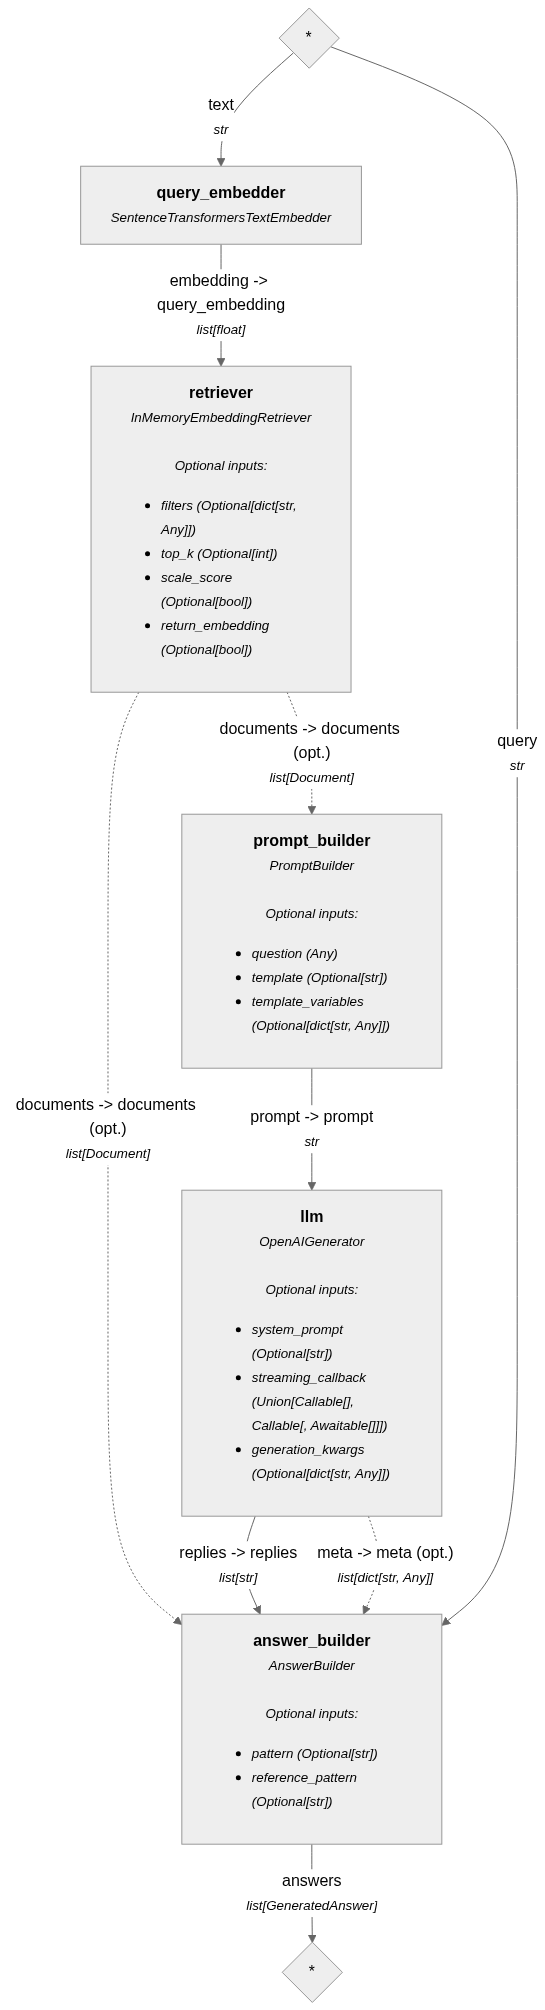

In [ ]:
basic_rag.show()

In [ ]:
q="What was NVIDIA's earnings?"
response = basic_rag.run(
                data={"query_embedder": {"text": q}, "prompt_builder": {"question": q}, "answer_builder": {"query": q}})

In [ ]:
response["answer_builder"]["answers"][0].data

'Net income for NVIDIA was $14,881 million.'

In [ ]:
[d.content for d in response['answer_builder']['answers'][0].documents]

["The information we\npost through these channels is not a part of this Quarterly Report on Form 10-Q. These channels may be updated from time to time on NVIDIA's investorrelations website.\n2\x0cPart I. Financial Information\nItem 1. Financial Statements (Unaudited)\nNVIDIA Corporation and SubsidiariesCondensed Consolidated Statements of Income(In millions, except per share data)\n(Unaudited) Three Months Ended Apr 28, 2024 Apr 30, 2023\nRevenue $ 26,044 $ 7,192 Cost of revenue 5,638 2,544 Gross profit 20,406 4,648 Operating expenses Research and development 2,720 1,875 Sales, general and administrative 777 633 Total operating expenses 3,497 2,508 Operating income 16,909 2,140 Interest income 359 150 Interest expense (64) (66)\nOther, net 75 (15)\nOther income (expense), net 370 69 Income before income tax 17,279 2,209 Income tax expense 2,398 166 Net income $ 14,881 $ 2,043 Net income per share:\nBasic $ 6.04 $ 0.83 Diluted $ 5.98 $ 0.82 Weighted average shares used in per share comp

## Evaluations

 - SAS ground truth
 - Context Relevance
 - Faithfulness

In [ ]:
import json
with open('/content/nvidia-GT.json') as f:
    gt = json.load(f)
import time

In [ ]:
predicted_answers = []
retrieved_contexts = []
questions=[]
answers=[]

for i in range(0,len(gt)):
  q = gt[i]['Question']
  questions.append(q)
  answers.append(gt[i]['Answer'])
  response = basic_rag.run(
      data={"query_embedder": {"text": q}, "prompt_builder": {"question": q}, "answer_builder": {"query": q}})
  predicted_answers.append(response["answer_builder"]["answers"][0].data)
  retrieved_contexts.append([d.content for d in response['answer_builder']['answers'][0].documents])

  time.sleep(1)
  print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
from haystack.components.evaluators import ContextRelevanceEvaluator, FaithfulnessEvaluator, SASEvaluator

eval_pipeline = Pipeline()
eval_pipeline.add_component("context_relevance", ContextRelevanceEvaluator(raise_on_failure=False))
eval_pipeline.add_component("faithfulness", FaithfulnessEvaluator(raise_on_failure=False))
eval_pipeline.add_component("sas", SASEvaluator())

eval_pipeline_results = eval_pipeline.run(
    {
        "context_relevance": {"questions": questions, "contexts": retrieved_contexts},
        "faithfulness": {"questions": questions, "contexts": retrieved_contexts, "predicted_answers": predicted_answers},
        "sas": {"predicted_answers": predicted_answers, "ground_truth_answers": answers},
    }
)

results = {
    "context_relevance": eval_pipeline_results['context_relevance'],
    "faithfulness": eval_pipeline_results['faithfulness'],
    "sas": eval_pipeline_results['sas']
}

100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


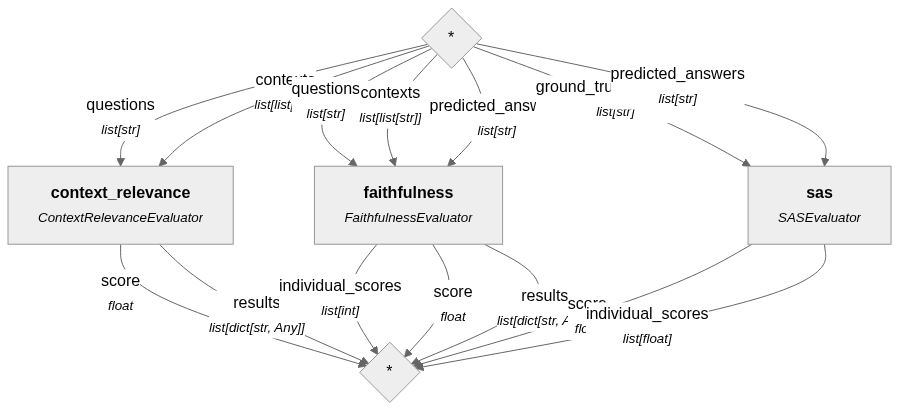

In [ ]:
eval_pipeline.show()

In [ ]:
inputs = {
				'questions': questions,
        'contexts': retrieved_contexts,
        'true_answers': answers,
        'predicted_answers': predicted_answers
     }

In [ ]:
from haystack.evaluation.eval_run_result import EvaluationRunResult
eval_results = EvaluationRunResult(run_name="basic RAG",inputs=inputs, results=results)

In [ ]:
eval_results.aggregated_report()

{'metrics': ['context_relevance', 'faithfulness', 'sas'],
 'score': [0.9, np.float64(0.95), np.float64(0.5930077597498894)]}

# Optimized Pipeline and Eval

In [ ]:
template = """
Answer the questions based on the given context. If the context is not relevant, say "I don't know"

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{ question }}
Answer:
"""

In [ ]:
from haystack.components.rankers import TransformersSimilarityRanker
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever, InMemoryEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder
ranker = TransformersSimilarityRanker(model="BAAI/bge-reranker-base")
from haystack.components.joiners import DocumentJoiner

document_joiner = DocumentJoiner()

hybrid_retrieval = Pipeline()
text_embedder = SentenceTransformersTextEmbedder(
    model="BAAI/bge-small-en-v1.5"
)

embedding_retriever = InMemoryEmbeddingRetriever(document_store)
bm25_retriever = InMemoryBM25Retriever(document_store)

hybrid_retrieval.add_component("text_embedder", text_embedder)
hybrid_retrieval.add_component("embedding_retriever", embedding_retriever)
hybrid_retrieval.add_component("bm25_retriever", bm25_retriever)
hybrid_retrieval.add_component("document_joiner", document_joiner)
hybrid_retrieval.add_component("ranker", ranker)
hybrid_retrieval.add_component("prompt_builder", PromptBuilder(template=template))
hybrid_retrieval.add_component("llm", OpenAIGenerator(model="gpt-3.5-turbo"))
hybrid_retrieval.add_component("answer_builder", AnswerBuilder())

hybrid_retrieval.connect("text_embedder", "embedding_retriever")
hybrid_retrieval.connect("bm25_retriever", "document_joiner")
hybrid_retrieval.connect("embedding_retriever", "document_joiner")
hybrid_retrieval.connect("document_joiner", "ranker")
hybrid_retrieval.connect("ranker", "prompt_builder.documents")
hybrid_retrieval.connect("prompt_builder", "llm")
hybrid_retrieval.connect("llm.replies", "answer_builder.replies")
hybrid_retrieval.connect("llm.meta", "answer_builder.meta")
hybrid_retrieval.connect("ranker", "answer_builder.documents")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - embedding_retriever: InMemoryEmbeddingRetriever
  - bm25_retriever: InMemoryBM25Retriever
  - document_joiner: DocumentJoiner
  - ranker: TransformersSimilarityRanker
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
  - answer_builder: AnswerBuilder
🛤️ Connections
  - text_embedder.embedding -> embedding_retriever.query_embedding (List[float])
  - embedding_retriever.documents -> document_joiner.documents (List[Document])
  - bm25_retriever.documents -> document_joiner.documents (List[Document])
  - document_joiner.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt_builder.documents (List[Document])
  - ranker.documents -> answer_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> answer_builder.replies (List[str])
  - llm.meta -> answer_builder.meta (List[Dict[str, Any]])

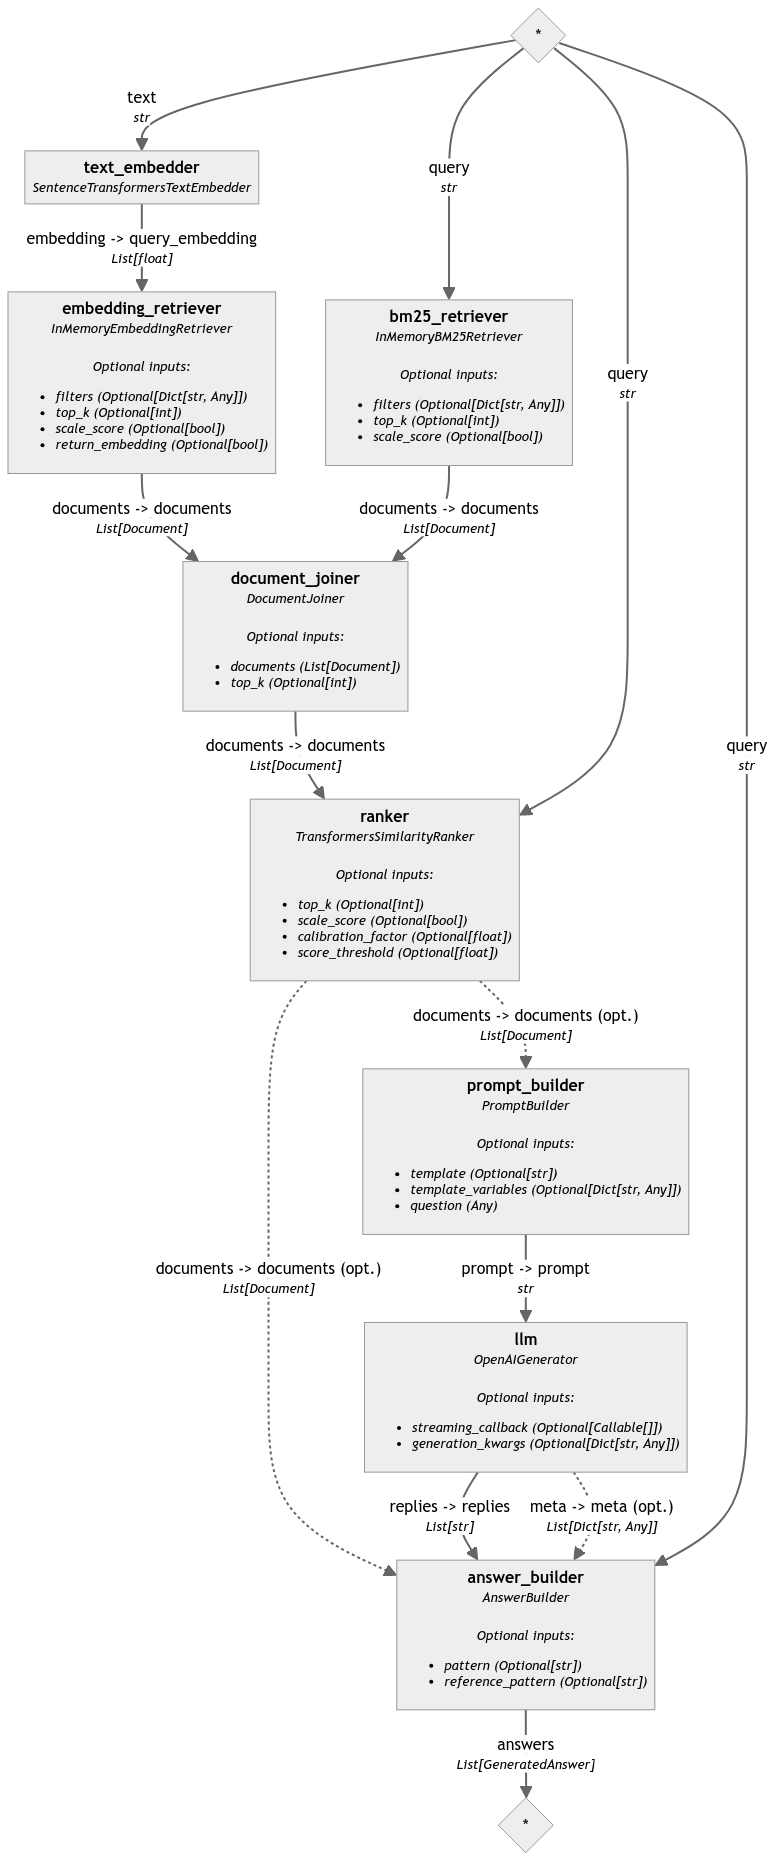

In [ ]:
hybrid_retrieval.show()

In [ ]:
q="What was NVIDIA's earnings?"
response = hybrid_retrieval.run(
                data={"text_embedder": {"text": q},"bm25_retriever": {"query": q},"ranker": {"query": q},
                      "prompt_builder": {"question": q}, "answer_builder": {"query": q}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
response["answer_builder"]["answers"][0].data

"NVIDIA's earnings were $14,881 million."

In [ ]:
predicted_answers = []
retrieved_contexts = []
questions=[]
answers=[]

for i in range(0,len(gt)):
  q = gt[i]['Question']
  questions.append(q)
  answers.append(gt[i]['Answer'])
  response = hybrid_retrieval.run(
                data={"text_embedder": {"text": q},"bm25_retriever": {"query": q},"ranker": {"query": q},
                      "prompt_builder": {"question": q}, "answer_builder": {"query": q}})
  predicted_answers.append(response["answer_builder"]["answers"][0].data)
  retrieved_contexts.append([d.content for d in response['answer_builder']['answers'][0].documents])

  time.sleep(1)
  print(i)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

4


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

6


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

7


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

8


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

9


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

10


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

11


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

12


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

13


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

14


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

15


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

16


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

17


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

18


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

19


In [ ]:
from haystack.components.evaluators import ContextRelevanceEvaluator, FaithfulnessEvaluator, SASEvaluator

eval_pipeline = Pipeline()
eval_pipeline.add_component("context_relevance", ContextRelevanceEvaluator(raise_on_failure=False))
eval_pipeline.add_component("faithfulness", FaithfulnessEvaluator(raise_on_failure=False))
eval_pipeline.add_component("sas", SASEvaluator())

eval_pipeline_results = eval_pipeline.run(
    {
        "context_relevance": {"questions": questions, "contexts": retrieved_contexts},
        "faithfulness": {"questions": questions, "contexts": retrieved_contexts, "predicted_answers": predicted_answers},
        "sas": {"predicted_answers": predicted_answers, "ground_truth_answers": answers},
    }
)

results = {
    "context_relevance": eval_pipeline_results['context_relevance'],
    "faithfulness": eval_pipeline_results['faithfulness'],
    "sas": eval_pipeline_results['sas']
}

100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


In [ ]:
inputs = {
				'questions': questions,
        'contexts': retrieved_contexts,
        'true_answers': answers,
        'predicted_answers': predicted_answers
     }

In [ ]:
from haystack.evaluation.eval_run_result import EvaluationRunResult
eval_results = EvaluationRunResult(run_name="Hybrid RAG",inputs=inputs, results=results)

In [ ]:
eval_results.aggregated_report()

,metrics,score
0,context_relevance,0.800000
1,faithfulness,0.950000
2,sas,0.623023
